# Decision Dependent Games Simulation
## Synthetic Linear Regression Problem with Location Families

We extend the linear regression example from Miller et. al. (http://arxiv.org/abs/2102.08570) to the multiplayer framework where the models of each player affect the distributions of data seen by all.

In [1]:
import numpy as np
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from dfo_player import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

np.random.seed(0)

The performative 2-player linear regression problem is set up as follows. For each player $k\in\{1,2\}$ we generate data

$$x^k \sim \mathcal{N}(0,\Sigma_{x^k}),\quad U^k \sim \mathcal{N}(0,\sigma_{y^k}), \quad y^k = \langle \beta^k, x^k \rangle + \langle \mu^k, \theta^k \rangle + \langle \gamma^k, \theta^{-k} \rangle + U^k$$

Where $x^k\in\mathbb{R}^d, y^k\in\mathbb{R}, U^k\in\mathbb{R}$. The performative effects are given by $\mu^k,\gamma^k$, which are drawn randomly by sampling a vector from the radius $\varepsilon^k$ spheres in $\mathbb{R}^{d_1+d_2}$ so that the distribution map for each player $k\in\{1,2\}$ is $\varepsilon^k$-sensitive.
$$\varepsilon^k = \sqrt{||\mu^k||_2^2+||\gamma^k||_2^2}$$
\
The loss function is quadratic
$$\ell((x^k,y^k);\theta^k) = \tfrac{1}{2}(y^k-{x^k}^T\theta^k)^2 = \tfrac{1}{2}||y^k||_2^2+\tfrac{1}{2}||{x^k}^T\theta^k||_2^2-y^k{x^k}^T\theta^k$$
so it is $1$-strongly convex in $\theta^k$ and $1$-smooth in $z^k$  
\
We showed that if $\ell^k(z^k,\theta^k)$ is $\eta^k$-strongly convex in $\theta^k$, is $\beta^k$-smooth in $z^k$, and the distribution map is $\varepsilon^k$-sensitive, then the game is convex, and $PR^k(\theta^k)$ for each player $k\in\{1,2\}$ is $\lambda^k$-weakly convex where $$\lambda^k=2\beta^k\varepsilon^k-\eta^k$$
If the performative risks are both strongly convex, then the game is diagonally strictly convex, so the game will have a unique Nash equilibrium, so we can enforce DSC by choosing parameters such that
$$2\beta^k\varepsilon^k\leq\eta^k$$
That is,
$$\varepsilon^k\leq\frac{1}{2} \iff DSC$$

# Configurations

In [2]:
d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_1 = 0.4  # Epsilon sensitivity parameters
epsilon_2 = 0.4

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.01  # Variance of y^k
sigma_y_p2 = 0.01

beta_p1 = np.random.normal(size=d_1)  # Linear parameter vector
beta_p2 = np.random.normal(size=d_2)

s_1 = sample_sphere(epsilon_1,d_1+d_2)  # Performativity parameters
mu_p1 = s_1[0:d_1]
gamma_p1 = s_1[d_1:]
s_2 = sample_sphere(epsilon_2,d_1+d_2)
mu_p2 = s_2[0:d_2]
gamma_p2 = s_2[d_2:]

#Fixing mu and gamma for testing purposes
if False:
    mu_p2 = np.array([2.1, -1.8])
    gamma_p2 = np.array([1.2, 0.9])
    mu_p1 = np.array([-2.8, 2.2])
    gamma_p1 = np.array([0.7, -0.3])

if False:
    mu_p1 = np.array([0, 0])
    gamma_p1 = np.array([1, 1])
    mu_p2 = np.array([0, 0])
    gamma_p2 = np.array([1, 1])

In [3]:
p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

# Run Game

In [11]:
p1_risks = []
p2_risks = []

num_rounds = 500000
delta = 1e-2
eta = 5e-3
batch = 1

player_two = DFOPlayer(delta,eta,batch)
player_one = DFOPlayer(delta,eta,batch)
game = DecisionDependentGame(player_one, player_two,
                             p1_data_params, p2_data_params,
                             p1_data_generating_func, p2_data_generating_func)

for i in range(2,num_rounds+1):
    
    game.theta_p1 = player_one.perturb_theta()
    game.theta_p2 = player_two.perturb_theta()
    
    PR_1_oracle, PR_2_oracle = game.evaluate_closed_perf_risk()
    
    game.theta_p1 = player_one.update_theta(PR_1_oracle,i)
    game.theta_p2 = player_two.update_theta(PR_2_oracle,i)
    
    p1_risks.append(PR_1_oracle)
    p2_risks.append(PR_2_oracle)
    
    #Change this flag if one wants to change print settings
    if i%(num_rounds/10)==0:
        print("---------------------")
        print(f"Iteration {i}")
        print("Player 1 risk:")
        print(PR_1_oracle)

        print("Player 2 risk")
        print(PR_2_oracle)

---------------------
Iteration 50000
Player 1 risk:
2.977671059896503
Player 2 risk
3.8169755352892465
---------------------
Iteration 100000
Player 1 risk:
2.9829434063248295
Player 2 risk
2.702785331532188
---------------------
Iteration 150000
Player 1 risk:
3.1722888788768757
Player 2 risk
2.1053191278114434
---------------------
Iteration 200000
Player 1 risk:
3.6690635861569154
Player 2 risk
1.780090950193965
---------------------
Iteration 250000
Player 1 risk:
4.586656460045302
Player 2 risk
1.62979688636792
---------------------
Iteration 300000
Player 1 risk:
6.2706478446751746
Player 2 risk
1.6395657795497438
---------------------
Iteration 350000
Player 1 risk:
9.754858521532967
Player 2 risk
1.8784832716518711
---------------------
Iteration 400000
Player 1 risk:
18.496378500811506
Player 2 risk
2.6510375390358876
---------------------
Iteration 450000
Player 1 risk:
51.99680324538434
Player 2 risk
5.627798128345368
---------------------
Iteration 500000
Player 1 risk:
57

## Evaluate the performative risks after DFO

In [5]:
# PR_1, PR_2 = game.evaluate_closed_perf_risk()
# print(f'Player 1 PR = {PR_1.round(3)}\tPlayer 2 PR = {PR_2.round(3)}')

In [6]:
print(player_one.theta_history[-1])
print(player_two.theta_history[-1])

[0.77269603 0.13341363]
[0.48357394 0.37336666]


In [7]:
game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

Player 1 PO = 0.149	Player 2 PO = 0.026


In [8]:
game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 SO = 0.151	Player 2 SO = 0.022


## Plots

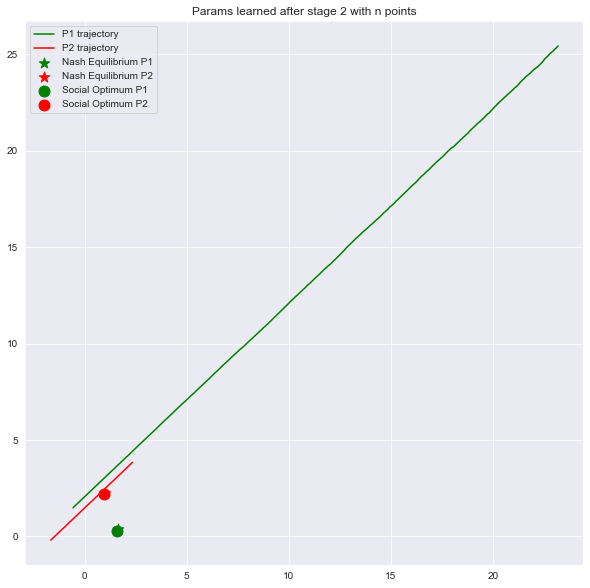

In [12]:
plt.figure(figsize=(10,10))
PO_1, PO_2 = game.solve_nash()
x_nash_p1 = PO_1[0]
y_nash_p1 = PO_1[1]
plt.scatter(x_nash_p1, y_nash_p1,
            label='Nash Equilibrium P1', marker='*', color='g', s=120)

x_nash_p2 = PO_2[0]
y_nash_p2 = PO_2[1]
plt.scatter(x_nash_p2,y_nash_p2,
            label='Nash Equilibrium P2', marker='*', color='r', s=120)

SO_1, SO_2 = game.solve_social_opt()
x_so_p1 = SO_1[0]
y_so_p1 = SO_1[1]
plt.scatter(x_so_p1, y_so_p1,
            label='Social Optimum P1', marker='o', color='g', s=120)

x_so_p2 = SO_2[0]
y_so_p2 = SO_2[1]
plt.scatter(x_so_p2,y_so_p2,
            label='Social Optimum P2', marker='o', color='r', s=120)

theta_1 = np.array(player_one.theta_history)
plt.plot(theta_1[:,0],theta_1[:,1],
         label='P1 trajectory', color='g')

theta_2 = np.array(player_two.theta_history)
plt.plot(theta_2[:,0],theta_2[:,1],
         label='P2 trajectory', color='r')

plt.legend()
plt.title("Params learned after stage 2 with n points")
plt.show()

In [10]:
u_ = np.array(player_one.u_history)